# DMT Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

- Understand linear viscoelastic response in the DMT framework
- Analyze G'/G'' crossover and its connection to Maxwell relaxation time
- Recognize that at fixed structure (λ₀), DMT reduces to a single Maxwell element
- Explore identifiability limits in SAOS (only 3 parameters recoverable)
- Visualize the effect of preshear state (λ₀) on linear response

## Prerequisites

- Notebook 01 (Flow Curves)
- Understanding of Maxwell model and linear viscoelasticity

## Runtime

~2-3 minutes (NLSQ + Bayesian inference)

## 1. Setup

### Google Colab Detection and Installation

In [1]:
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

if IN_COLAB:
    print("Installing RheoJAX...")
    !pip install -q rheojax
    
    import os
    os.environ['JAX_ENABLE_X64'] = '1'
    print("JAX float64 enabled")

Running in local environment


### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit

%matplotlib inline

# RheoJAX imports with safe JAX configuration
from rheojax.core.jax_config import safe_import_jax, verify_float64
jax, jnp = safe_import_jax()

from rheojax.models import DMTLocal
from rheojax.models.dmt._kernels import saos_moduli_maxwell, elastic_modulus, viscosity_exponential
from rheojax.core.data import RheoData

# Bayesian tools
import arviz as az

# Verify float64 precision
verify_float64()
print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


## 2. Theory: SAOS in the DMT Framework

### Linear Viscoelasticity at Fixed Structure

In Small Amplitude Oscillatory Shear (SAOS), the applied strain is so small that the structure parameter λ remains essentially constant at its initial value λ₀. This means:

- **No structure evolution**: dλ/dt ≈ 0 (small amplitude → negligible rejuvenation)
- **Linear response**: Stress is linearly proportional to strain

### Maxwell Element Analogy

At fixed λ₀, the DMT model (with elasticity) behaves as a **single Maxwell element** with:

- **Elastic modulus**: G = G(λ₀) = G₀(λ₀)^(m_G)
- **Viscosity**: η = η(λ₀) from closure (exponential or HB)
- **Relaxation time**: θ₁ = η/G

### SAOS Moduli

For a Maxwell element subjected to γ(t) = γ₀sin(ωt):

$$G'(\omega) = G \frac{(\omega\theta_1)^2}{1 + (\omega\theta_1)^2}$$

$$G''(\omega) = G \frac{\omega\theta_1}{1 + (\omega\theta_1)^2} + \eta_\infty \omega$$

Where:
- The first term in G'' is the Maxwell contribution
- η∞·ω is the Newtonian solvent contribution

### Special Case: Fully Built Structure (λ₀ = 1)

At λ₀ = 1:
- G = G₀ (maximum elasticity)
- η = η₀ (maximum viscosity)
- θ₁ = η₀/G₀

This is the equilibrium state of an unsheared material.

### Identifiability

From SAOS data alone at fixed λ₀, we can only identify:
1. **G₀** (plateau modulus)
2. **η₀** (zero-shear viscosity)
3. **η∞** (infinite-shear viscosity)

The thixotropic parameters (a, c, t_eq, m_G) are **not identifiable** from SAOS alone because the structure doesn't evolve. We need transient tests (startup, creep) to probe structure evolution.

## 3. Generate Synthetic SAOS Data

We'll create synthetic data from a calibrated DMT model with known parameters.

In [3]:
# Calibrated parameters (from previous notebooks)
calib_params = {
    "eta_0": 1.5e4,    # Pa·s (zero-shear viscosity)
    "eta_inf": 0.3,    # Pa·s (infinite-shear viscosity)
    "a": 0.8,          # Rejuvenation rate coefficient
    "c": 0.7,          # Shear-rate exponent
    "G0": 500.0,       # Pa (elastic modulus at λ=1)
    "m_G": 1.0,        # Structure exponent for G
    "t_eq": 50.0,      # s (equilibration time)
}

# Create model and set parameters
model_true = DMTLocal(closure="exponential", include_elasticity=True)
for param_name, value in calib_params.items():
    if param_name in model_true.parameters:
        model_true.parameters[param_name].value = value

# Generate frequency sweep
omega = np.logspace(-2, 3, 50)  # 0.01 to 1000 rad/s

# Predict SAOS at fully built structure (λ₀ = 1)
G_prime_true, G_double_prime_true = model_true.predict_saos(omega, lam_0=1.0)

# Add 3% Gaussian noise
np.random.seed(42)
noise_level = 0.03
G_prime_noisy = G_prime_true * (1 + noise_level * np.random.randn(len(omega)))
G_double_prime_noisy = G_double_prime_true * (1 + noise_level * np.random.randn(len(omega)))

# Combine into complex modulus
G_star = G_prime_noisy + 1j * G_double_prime_noisy

print(f"Generated {len(omega)} frequency points")
print(f"Frequency range: {omega[0]:.2e} - {omega[-1]:.2e} rad/s")
print(f"Noise level: {noise_level*100}%")

Generated 50 frequency points
Frequency range: 1.00e-02 - 1.00e+03 rad/s
Noise level: 3.0%


### Visualize Synthetic Data

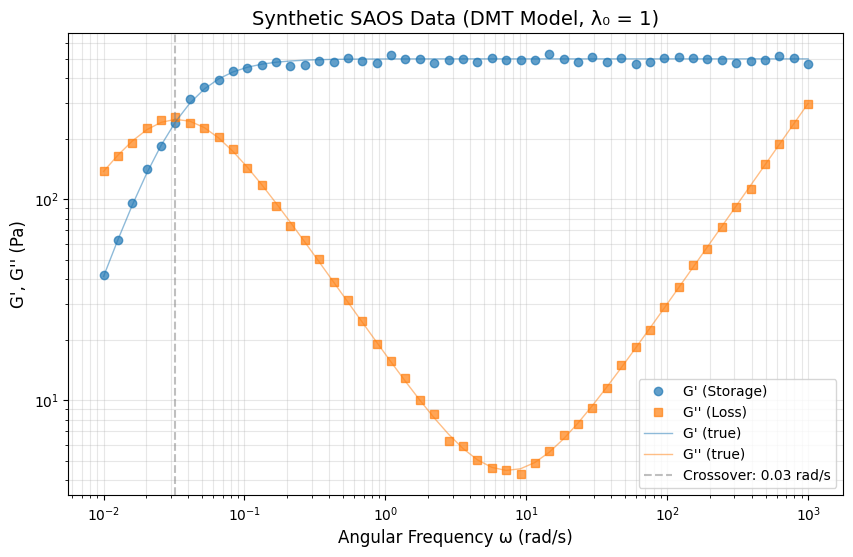


Crossover frequency ω_c = 0.032 rad/s
Expected relaxation time θ₁ = η₀/G₀ = 30.0 s
Expected ω_c ≈ 1/θ₁ = 0.0333 rad/s


In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot G' and G''
ax.loglog(omega, G_prime_noisy, 'o', label="G' (Storage)", markersize=6, alpha=0.7)
ax.loglog(omega, G_double_prime_noisy, 's', label="G'' (Loss)", markersize=6, alpha=0.7)

# Plot noise-free truth (thin lines)
ax.loglog(omega, G_prime_true, '-', color='C0', linewidth=1, alpha=0.5, label="G' (true)")
ax.loglog(omega, G_double_prime_true, '-', color='C1', linewidth=1, alpha=0.5, label="G'' (true)")

# Mark crossover frequency
crossover_idx = np.argmin(np.abs(G_prime_true - G_double_prime_true))
omega_c = omega[crossover_idx]
ax.axvline(omega_c, color='gray', linestyle='--', alpha=0.5, label=f'Crossover: {omega_c:.2f} rad/s')

ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel("G', G'' (Pa)", fontsize=12)
ax.set_title('Synthetic SAOS Data (DMT Model, λ₀ = 1)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3)

display(fig)
plt.close(fig)

print(f"\nCrossover frequency ω_c = {omega_c:.3f} rad/s")
print(f"Expected relaxation time θ₁ = η₀/G₀ = {calib_params['eta_0']/calib_params['G0']:.1f} s")
print(f"Expected ω_c ≈ 1/θ₁ = {calib_params['G0']/calib_params['eta_0']:.4f} rad/s")

## 4. NLSQ Fitting

We'll fit only the identifiable parameters: G₀, η₀, η∞.

Since SAOS doesn't probe structure evolution, we fix the thixotropic parameters at arbitrary values.

In [5]:
# Define SAOS residual function for fitting
def saos_residual(omega, G0, eta_0, eta_inf):
    """
    Compute SAOS moduli for a Maxwell element.
    
    At λ₀=1: G=G₀, η=η₀, θ₁=η₀/G₀
    """
    omega_jax = jnp.asarray(omega)
    G = G0
    eta = eta_0
    theta_1 = eta / G
    
    # Maxwell element formulas
    omega_theta = omega_jax * theta_1
    G_prime = G * omega_theta**2 / (1 + omega_theta**2)
    G_double_prime = G * omega_theta / (1 + omega_theta**2) + eta_inf * omega_jax
    
    # Return complex modulus
    return G_prime + 1j * G_double_prime

def saos_residual_scipy(omega, G0, eta_0, eta_inf):
    """scipy-compatible wrapper that returns real values (stacked G', G'')."""
    G_star = saos_residual(omega, G0, eta_0, eta_inf)
    # Stack G' and G'' for scipy curve_fit
    return np.concatenate([np.real(G_star), np.imag(G_star)])

# Create model for reference
model_fit = DMTLocal(closure="exponential", include_elasticity=True)

# Perform NLSQ fitting using scipy.optimize.curve_fit
# Note: DMT model.fit() for SAOS is not implemented, so we use scipy directly
print("Running NLSQ optimization with scipy.optimize.curve_fit...")

# Helper function for computing fit quality
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Handle complex numbers
    if np.iscomplexobj(y_true):
        y_true_flat = np.concatenate([np.real(y_true), np.imag(y_true)])
        y_pred_flat = np.concatenate([np.real(y_pred), np.imag(y_pred)])
    else:
        y_true_flat = y_true.ravel() if y_true.ndim > 1 else y_true
        y_pred_flat = y_pred.ravel() if y_pred.ndim > 1 else y_pred
    residuals = y_true_flat - y_pred_flat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true_flat - np.mean(y_true_flat))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Initial guesses
p0 = [300.0, 1e4, 1.0]

# Bounds (lower, upper)
bounds = (
    [10.0, 100.0, 0.01],  # lower
    [5000.0, 1e6, 10.0]   # upper
)

# Stack data for scipy (G' followed by G'')
y_data_stacked = np.concatenate([G_prime_noisy, G_double_prime_noisy])

# Run scipy curve_fit
popt, pcov = curve_fit(
    saos_residual_scipy,
    omega,
    y_data_stacked,
    p0=p0,
    bounds=bounds,
    maxfev=5000
)

# Extract fitted parameters
fitted_params = {
    'G0': popt[0],
    'eta_0': popt[1],
    'eta_inf': popt[2]
}

# Compute metrics
G_star_pred = saos_residual(omega, *popt)
metrics = compute_fit_quality(G_star, G_star_pred)

print("\n" + "="*60)
print("NLSQ Fitting Results")
print("="*60)
print(f"{'Parameter':<15} {'True':<15} {'Fitted':<15} {'Error %':<10}")
print("-"*60)

for param_name in ['G0', 'eta_0', 'eta_inf']:
    true_val = calib_params[param_name]
    fitted_val = fitted_params[param_name]
    error_pct = abs(fitted_val - true_val) / true_val * 100
    print(f"{param_name:<15} {true_val:<15.3e} {fitted_val:<15.3e} {error_pct:<10.2f}")

print("-"*60)
print(f"R² = {metrics['R2']:.6f}")

Running NLSQ optimization with scipy.optimize.curve_fit...



NLSQ Fitting Results
Parameter       True            Fitted          Error %   
------------------------------------------------------------
G0              5.000e+02       4.948e+02       1.04      
eta_0           1.500e+04       1.513e+04       0.88      
eta_inf         3.000e-01       2.989e-01       0.38      
------------------------------------------------------------
R² = 0.998103


### Visualize NLSQ Fit

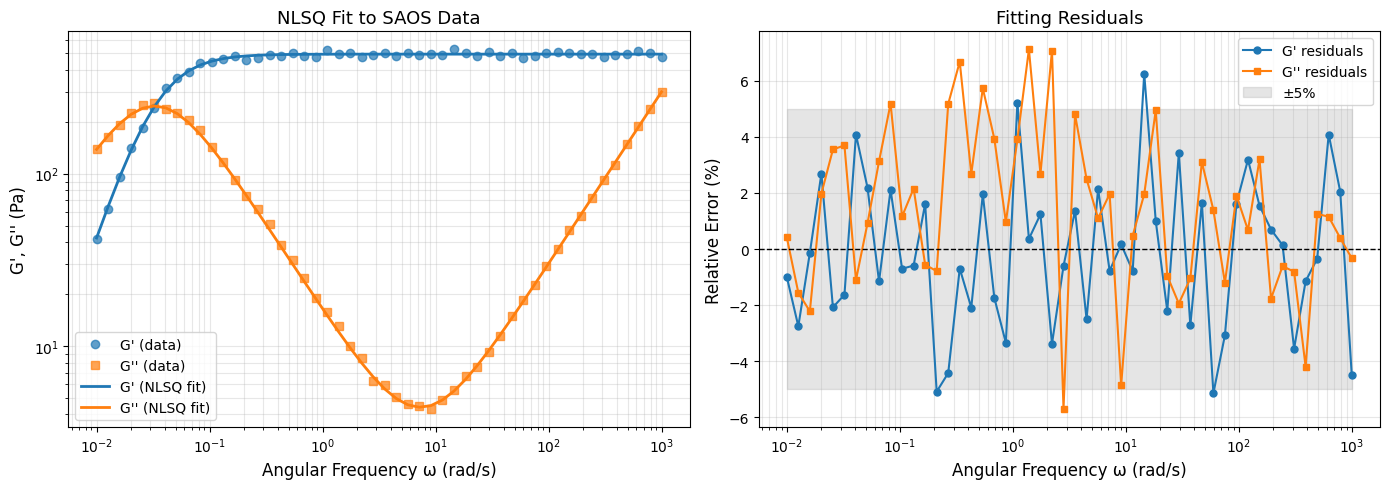

In [6]:
# Predict with fitted parameters
G_star_fit = saos_residual(omega, 
                           fitted_params['G0'], 
                           fitted_params['eta_0'], 
                           fitted_params['eta_inf'])

G_prime_fit = np.real(G_star_fit)
G_double_prime_fit = np.imag(G_star_fit)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G' and G'' vs frequency
ax1.loglog(omega, G_prime_noisy, 'o', label="G' (data)", markersize=6, alpha=0.7)
ax1.loglog(omega, G_double_prime_noisy, 's', label="G'' (data)", markersize=6, alpha=0.7)
ax1.loglog(omega, G_prime_fit, '-', color='C0', linewidth=2, label="G' (NLSQ fit)")
ax1.loglog(omega, G_double_prime_fit, '-', color='C1', linewidth=2, label="G'' (NLSQ fit)")

ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel("G', G'' (Pa)", fontsize=12)
ax1.set_title('NLSQ Fit to SAOS Data', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, which='both', alpha=0.3)

# Right: Residuals
residuals_prime = (G_prime_noisy - G_prime_fit) / G_prime_noisy * 100
residuals_double_prime = (G_double_prime_noisy - G_double_prime_fit) / G_double_prime_noisy * 100

ax2.semilogx(omega, residuals_prime, 'o-', label="G' residuals", markersize=5)
ax2.semilogx(omega, residuals_double_prime, 's-', label="G'' residuals", markersize=5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.fill_between(omega, -5, 5, alpha=0.2, color='gray', label='±5%')

ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('Relative Error (%)', fontsize=12)
ax2.set_title('Fitting Residuals', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

We'll perform Bayesian inference to quantify parameter uncertainty. The DMT model's BayesianMixin automatically handles complex-valued data by splitting into real and imaginary parts.

In [7]:
# Custom Bayesian inference for SAOS using NumPyro
# Note: DMT model.fit_bayesian() for SAOS is not implemented, so we use NumPyro directly
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def saos_model(omega, G_prime_obs, G_double_prime_obs):
    """NumPyro model for SAOS fitting."""
    # Priors (use NLSQ as warm-start)
    G0 = numpyro.sample("G0", dist.Uniform(10.0, 5000.0))
    eta_0 = numpyro.sample("eta_0", dist.Uniform(100.0, 1e6))
    eta_inf = numpyro.sample("eta_inf", dist.Uniform(0.01, 10.0))
    
    # Maxwell model prediction
    theta_1 = eta_0 / G0
    omega_theta = omega * theta_1
    G_prime_pred = G0 * omega_theta**2 / (1 + omega_theta**2)
    G_double_prime_pred = G0 * omega_theta / (1 + omega_theta**2) + eta_inf * omega
    
    # Likelihood (Gaussian with estimated noise)
    sigma_G_prime = numpyro.sample("sigma_G_prime", dist.HalfNormal(50.0))
    sigma_G_double_prime = numpyro.sample("sigma_G_double_prime", dist.HalfNormal(50.0))
    
    numpyro.sample("G_prime", dist.Normal(G_prime_pred, sigma_G_prime), obs=G_prime_obs)
    numpyro.sample("G_double_prime", dist.Normal(G_double_prime_pred, sigma_G_double_prime), obs=G_double_prime_obs)

print("Running Bayesian inference (NUTS sampler) with NumPyro...")
print("This may take 1-2 minutes...\n")

# Run NUTS
rng_key = jax.random.PRNGKey(42)
kernel = NUTS(saos_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key, omega, jnp.array(G_prime_noisy), jnp.array(G_double_prime_noisy))

# Create result container
class BayesResult:
    def __init__(self, samples):
        self.posterior_samples = samples

bayes_result = BayesResult(mcmc.get_samples())

print("\nBayesian inference completed!")

Running Bayesian inference (NUTS sampler) with NumPyro...
This may take 1-2 minutes...



/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_43029/3809317136.py:33: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<17:26,  2.87it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 98/3000 [00:00<00:10, 283.30it/s, 127 steps of size 3.03e-03. acc. prob=0.75]

warmup:   6%|▌         | 171/3000 [00:00<00:06, 412.92it/s, 31 steps of size 1.40e-01. acc. prob=0.77]

warmup:  10%|█         | 305/3000 [00:00<00:03, 685.39it/s, 15 steps of size 2.77e-01. acc. prob=0.78]

warmup:  15%|█▍        | 445/3000 [00:00<00:02, 883.22it/s, 7 steps of size 3.84e-01. acc. prob=0.79] 

warmup:  19%|█▉        | 574/3000 [00:00<00:02, 1002.72it/s, 7 steps of size 8.39e-01. acc. prob=0.79]

warmup:  24%|██▎       | 709/3000 [00:00<00:02, 1104.20it/s, 7 steps of size 8.69e-01. acc. prob=0.79]

warmup:  28%|██▊       | 830/3000 [00:01<00:02, 935.98it/s, 7 steps of size 4.71e-01. acc. prob=0.79] 

warmup:  33%|███▎      | 987/3000 [00:01<00:01, 1099.59it/s, 15 steps of size 2.29e-01. acc. prob=0.79]

sample:  40%|████      | 1202/3000 [00:01<00:01, 1381.89it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  45%|████▌     | 1352/3000 [00:01<00:01, 1333.10it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  50%|████▉     | 1494/3000 [00:01<00:01, 1330.90it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  55%|█████▍    | 1636/3000 [00:01<00:01, 1332.51it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  60%|█████▉    | 1796/3000 [00:01<00:00, 1405.16it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  65%|██████▌   | 1955/3000 [00:01<00:00, 1450.96it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  71%|███████   | 2116/3000 [00:01<00:00, 1488.83it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  76%|███████▌  | 2267/3000 [00:02<00:00, 1388.01it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  80%|████████  | 2409/3000 [00:02<00:00, 1360.94it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  85%|████████▌ | 2553/3000 [00:02<00:00, 1382.50it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  90%|████████▉ | 2693/3000 [00:02<00:00, 1383.28it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample:  96%|█████████▌| 2876/3000 [00:02<00:00, 1511.10it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1148.83it/s, 7 steps of size 4.73e-01. acc. prob=0.93]

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   3%|▎         | 101/3000 [00:00<00:03, 959.77it/s, 767 steps of size 5.82e-02. acc. prob=0.76]

warmup:   8%|▊         | 228/3000 [00:00<00:02, 1110.16it/s, 7 steps of size 3.17e-01. acc. prob=0.78] 

warmup:  13%|█▎        | 389/3000 [00:00<00:01, 1318.11it/s, 7 steps of size 3.25e-01. acc. prob=0.78]

warmup:  18%|█▊        | 537/3000 [00:00<00:01, 1360.30it/s, 7 steps of size 4.28e-01. acc. prob=0.79]

warmup:  24%|██▍       | 729/3000 [00:00<00:01, 1557.23it/s, 7 steps of size 4.13e-01. acc. prob=0.79]

warmup:  30%|██▉       | 886/3000 [00:00<00:01, 1415.62it/s, 3 steps of size 9.80e-01. acc. prob=0.79]

sample:  34%|███▍      | 1030/3000 [00:00<00:01, 1349.20it/s, 3 steps of size 5.13e-01. acc. prob=0.92]

sample:  40%|███▉      | 1190/3000 [00:00<00:01, 1421.05it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  44%|████▍     | 1335/3000 [00:01<00:01, 1244.17it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  50%|█████     | 1509/3000 [00:01<00:01, 1375.26it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  55%|█████▌    | 1653/3000 [00:01<00:00, 1390.94it/s, 3 steps of size 5.13e-01. acc. prob=0.92]

sample:  61%|██████    | 1816/3000 [00:01<00:00, 1455.98it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  66%|██████▌   | 1965/3000 [00:01<00:00, 1407.23it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  71%|███████   | 2123/3000 [00:01<00:00, 1443.46it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  77%|███████▋  | 2300/3000 [00:01<00:00, 1532.57it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  83%|████████▎ | 2487/3000 [00:01<00:00, 1629.28it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  88%|████████▊ | 2652/3000 [00:01<00:00, 1506.08it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  94%|█████████▎| 2806/3000 [00:02<00:00, 1322.04it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample:  99%|█████████▉| 2981/3000 [00:02<00:00, 1431.15it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1408.21it/s, 7 steps of size 5.13e-01. acc. prob=0.92]

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   4%|▍         | 120/3000 [00:00<00:02, 1191.09it/s, 63 steps of size 9.27e-02. acc. prob=0.77]

warmup:   8%|▊         | 245/3000 [00:00<00:02, 1224.49it/s, 7 steps of size 2.46e-01. acc. prob=0.78] 

warmup:  14%|█▍        | 421/3000 [00:00<00:01, 1468.32it/s, 7 steps of size 3.30e-01. acc. prob=0.79]

warmup:  19%|█▉        | 570/3000 [00:00<00:01, 1475.73it/s, 7 steps of size 3.67e-01. acc. prob=0.79]

warmup:  26%|██▌       | 776/3000 [00:00<00:01, 1685.27it/s, 7 steps of size 4.92e-01. acc. prob=0.79]

warmup:  32%|███▏      | 945/3000 [00:00<00:01, 1605.08it/s, 3 steps of size 3.71e-01. acc. prob=0.79]

sample:  37%|███▋      | 1107/3000 [00:00<00:01, 1125.53it/s, 3 steps of size 4.83e-01. acc. prob=0.93]

sample:  42%|████▏     | 1263/3000 [00:00<00:01, 1229.49it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  48%|████▊     | 1434/3000 [00:01<00:01, 1351.88it/s, 3 steps of size 4.83e-01. acc. prob=0.92]

sample:  53%|█████▎    | 1583/3000 [00:01<00:01, 1332.53it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  58%|█████▊    | 1726/3000 [00:01<00:00, 1318.71it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  64%|██████▍   | 1920/3000 [00:01<00:00, 1484.47it/s, 3 steps of size 4.83e-01. acc. prob=0.92]

sample:  70%|███████   | 2107/3000 [00:01<00:00, 1590.22it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  76%|███████▌  | 2272/3000 [00:01<00:00, 1499.91it/s, 3 steps of size 4.83e-01. acc. prob=0.92]

sample:  81%|████████  | 2427/3000 [00:01<00:00, 1406.47it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  86%|████████▌ | 2575/3000 [00:01<00:00, 1425.12it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  91%|█████████ | 2731/3000 [00:01<00:00, 1461.52it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample:  98%|█████████▊| 2932/3000 [00:02<00:00, 1614.91it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1448.77it/s, 7 steps of size 4.83e-01. acc. prob=0.92]

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   2%|▏         | 72/3000 [00:00<00:04, 667.25it/s, 31 steps of size 4.91e-03. acc. prob=0.75]

warmup:   6%|▌         | 172/3000 [00:00<00:03, 852.90it/s, 63 steps of size 1.12e-01. acc. prob=0.77]

warmup:  10%|▉         | 289/3000 [00:00<00:02, 993.27it/s, 15 steps of size 2.34e-01. acc. prob=0.78]

warmup:  14%|█▍        | 421/3000 [00:00<00:02, 1119.39it/s, 7 steps of size 6.52e-01. acc. prob=0.79]

warmup:  18%|█▊        | 549/3000 [00:00<00:02, 1141.16it/s, 3 steps of size 5.85e-01. acc. prob=0.79]

warmup:  22%|██▏       | 664/3000 [00:00<00:02, 991.57it/s, 7 steps of size 5.18e-01. acc. prob=0.79] 

warmup:  26%|██▌       | 767/3000 [00:00<00:02, 959.93it/s, 3 steps of size 8.22e-01. acc. prob=0.79]

warmup:  30%|███       | 905/3000 [00:00<00:01, 1064.55it/s, 7 steps of size 6.39e-01. acc. prob=0.79]

sample:  34%|███▍      | 1014/3000 [00:00<00:01, 1040.42it/s, 7 steps of size 5.34e-01. acc. prob=0.94]

sample:  37%|███▋      | 1120/3000 [00:01<00:02, 939.36it/s, 7 steps of size 5.34e-01. acc. prob=0.93] 

sample:  43%|████▎     | 1278/3000 [00:01<00:01, 1104.08it/s, 7 steps of size 5.34e-01. acc. prob=0.92]

sample:  47%|████▋     | 1411/3000 [00:01<00:01, 1165.98it/s, 7 steps of size 5.34e-01. acc. prob=0.92]

sample:  52%|█████▏    | 1572/3000 [00:01<00:01, 1290.24it/s, 7 steps of size 5.34e-01. acc. prob=0.92]

sample:  57%|█████▋    | 1723/3000 [00:01<00:00, 1352.80it/s, 3 steps of size 5.34e-01. acc. prob=0.92]

sample:  62%|██████▏   | 1861/3000 [00:01<00:00, 1290.09it/s, 7 steps of size 5.34e-01. acc. prob=0.92]

sample:  67%|██████▋   | 2005/3000 [00:01<00:00, 1331.43it/s, 3 steps of size 5.34e-01. acc. prob=0.92]

sample:  71%|███████▏  | 2140/3000 [00:01<00:00, 1232.12it/s, 3 steps of size 5.34e-01. acc. prob=0.92]

sample:  76%|███████▌  | 2266/3000 [00:02<00:00, 1151.61it/s, 7 steps of size 5.34e-01. acc. prob=0.91]

sample:  79%|███████▉  | 2384/3000 [00:02<00:00, 907.73it/s, 7 steps of size 5.34e-01. acc. prob=0.91] 

sample:  86%|████████▌ | 2565/3000 [00:02<00:00, 1114.88it/s, 7 steps of size 5.34e-01. acc. prob=0.91]

sample:  91%|█████████ | 2721/3000 [00:02<00:00, 1224.08it/s, 7 steps of size 5.34e-01. acc. prob=0.91]

sample:  95%|█████████▌| 2855/3000 [00:02<00:00, 1103.11it/s, 7 steps of size 5.34e-01. acc. prob=0.91]

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1125.39it/s, 7 steps of size 5.34e-01. acc. prob=0.91]


Bayesian inference completed!


### Diagnostics

In [8]:
# Compute diagnostics
import arviz as az

print("="*60)
print("Bayesian Diagnostics")
print("="*60)

# Convert to InferenceData for diagnostics
idata = az.from_dict(
    posterior={
        param: bayes_result.posterior_samples[param].reshape(4, -1)
        for param in ['G0', 'eta_0', 'eta_inf']
        if param in bayes_result.posterior_samples
    }
)

# Get summary with R-hat and ESS
summary = az.summary(idata, var_names=['G0', 'eta_0', 'eta_inf'])
print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

print("-"*60)
print("R-hat < 1.01: Excellent convergence")
print("ESS > 400: Good effective sample size")

Bayesian Diagnostics
              mean       sd     hdi_3%    hdi_97%  ess_bulk  r_hat
G0         499.067    1.452    496.370    501.774    8203.0    1.0
eta_0    15036.136  108.666  14837.651  15247.113    8503.0    1.0
eta_inf      0.299    0.002      0.296      0.302   10049.0    1.0
------------------------------------------------------------
R-hat < 1.01: Excellent convergence
ESS > 400: Good effective sample size


### Trace Plot

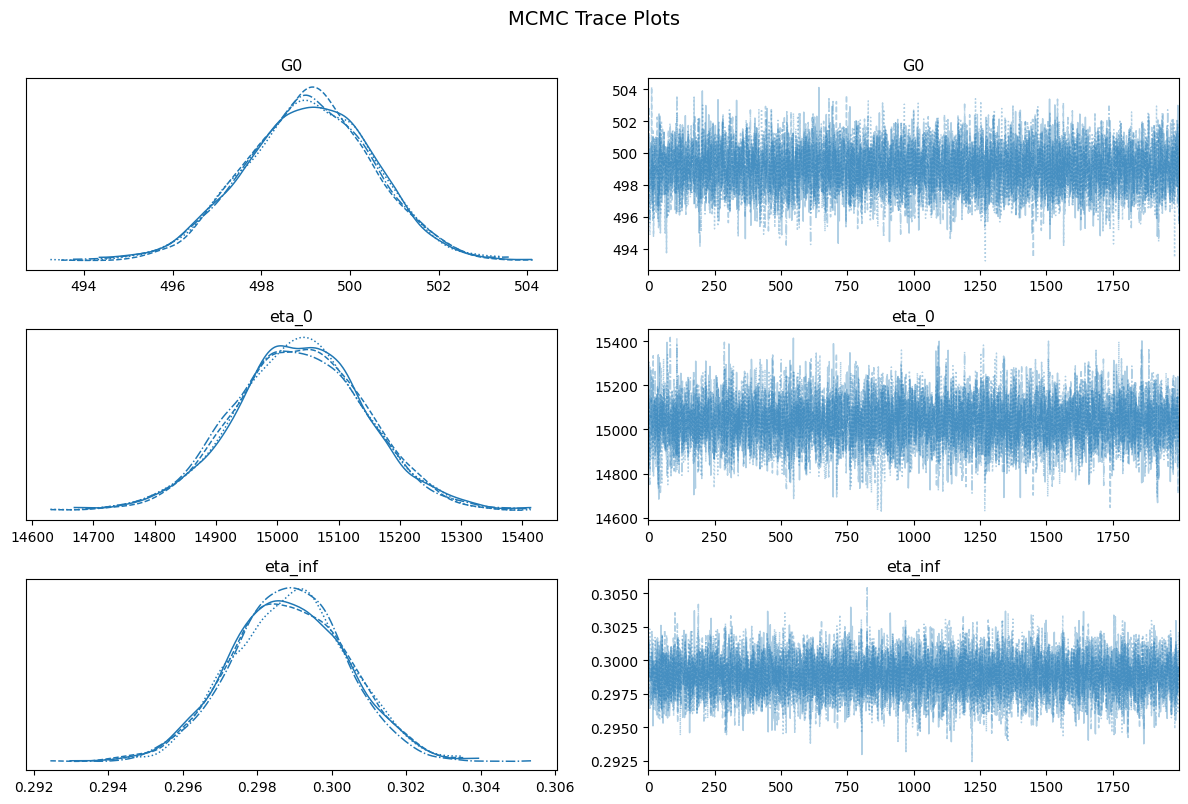

In [9]:
# Convert to ArviZ InferenceData
idata = az.from_dict(
    posterior={
        param: bayes_result.posterior_samples[param].reshape(4, -1)
        for param in ['G0', 'eta_0', 'eta_inf']
    }
)

# Trace plot
axes = az.plot_trace(idata, compact=True, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle('MCMC Trace Plots', fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

### Posterior Predictive Check

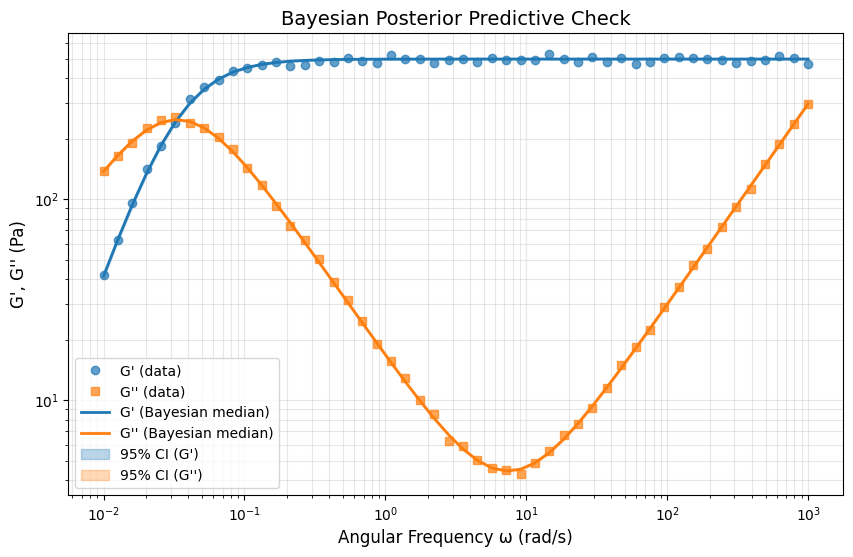

In [10]:
# Sample from posterior for predictions
n_posterior_samples = 200
sample_indices = np.random.choice(len(bayes_result.posterior_samples['G0']), 
                                  size=n_posterior_samples, 
                                  replace=False)

G_prime_samples = []
G_double_prime_samples = []

for idx in sample_indices:
    G0_sample = bayes_result.posterior_samples['G0'][idx]
    eta_0_sample = bayes_result.posterior_samples['eta_0'][idx]
    eta_inf_sample = bayes_result.posterior_samples['eta_inf'][idx]
    
    G_star_sample = saos_residual(omega, G0_sample, eta_0_sample, eta_inf_sample)
    G_prime_samples.append(np.real(G_star_sample))
    G_double_prime_samples.append(np.imag(G_star_sample))

G_prime_samples = np.array(G_prime_samples)
G_double_prime_samples = np.array(G_double_prime_samples)

# Compute credible intervals
G_prime_lower = np.percentile(G_prime_samples, 2.5, axis=0)
G_prime_upper = np.percentile(G_prime_samples, 97.5, axis=0)
G_prime_median = np.percentile(G_prime_samples, 50, axis=0)

G_double_prime_lower = np.percentile(G_double_prime_samples, 2.5, axis=0)
G_double_prime_upper = np.percentile(G_double_prime_samples, 97.5, axis=0)
G_double_prime_median = np.percentile(G_double_prime_samples, 50, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Data
ax.loglog(omega, G_prime_noisy, 'o', label="G' (data)", markersize=6, alpha=0.7, color='C0')
ax.loglog(omega, G_double_prime_noisy, 's', label="G'' (data)", markersize=6, alpha=0.7, color='C1')

# Posterior median
ax.loglog(omega, G_prime_median, '-', linewidth=2, label="G' (Bayesian median)", color='C0')
ax.loglog(omega, G_double_prime_median, '-', linewidth=2, label="G'' (Bayesian median)", color='C1')

# Credible intervals
ax.fill_between(omega, G_prime_lower, G_prime_upper, alpha=0.3, color='C0', label='95% CI (G\')')
ax.fill_between(omega, G_double_prime_lower, G_double_prime_upper, alpha=0.3, color='C1', label='95% CI (G\'\')')

ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel("G', G'' (Pa)", fontsize=12)
ax.set_title('Bayesian Posterior Predictive Check', fontsize=14)
ax.legend(fontsize=10, loc='best')
ax.grid(True, which='both', alpha=0.3)

display(fig)
plt.close(fig)

## 6. Effect of Preshear State (λ₀)

The SAOS response depends on the initial structure λ₀. A material with partially broken structure (λ₀ < 1) will have lower moduli and a shifted crossover frequency.

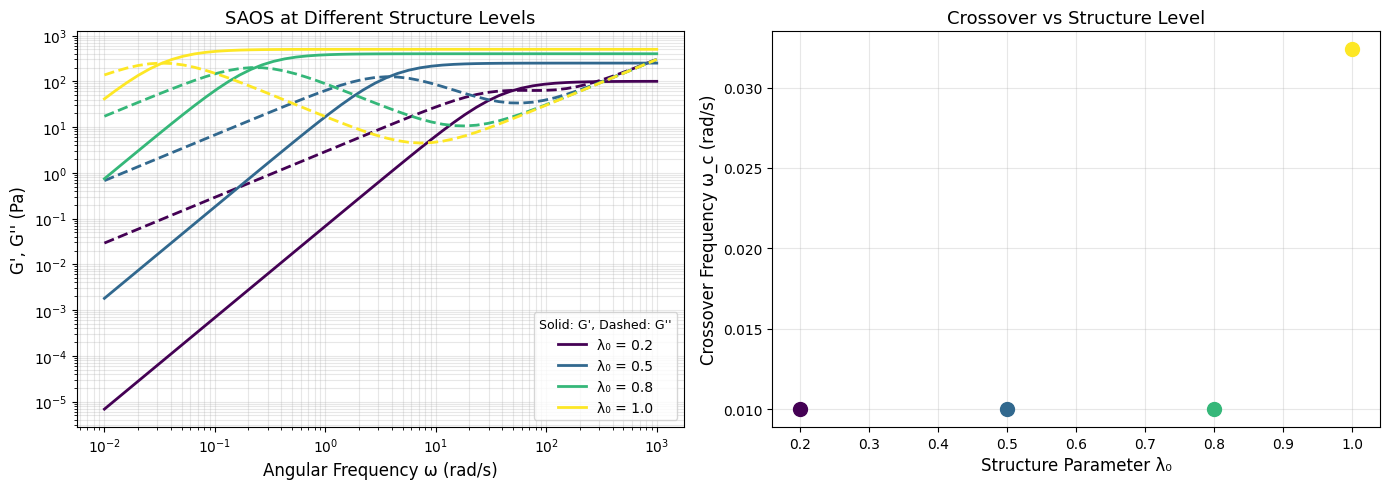


Observations:
- Lower λ₀ → Lower moduli (less elastic network)
- Crossover frequency shifts with structure
- SAOS alone cannot distinguish thixotropy from simple viscoelasticity!


In [11]:
# Predict SAOS at different structure levels
lambda_values = [0.2, 0.5, 0.8, 1.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for lam, color in zip(lambda_values, colors):
    G_prime, G_double_prime = model_true.predict_saos(omega, lam_0=lam)
    
    ax1.loglog(omega, G_prime, '-', linewidth=2, color=color, label=f'λ₀ = {lam}')
    ax1.loglog(omega, G_double_prime, '--', linewidth=2, color=color)
    
    # Find crossover
    crossover_idx = np.argmin(np.abs(np.asarray(G_prime) - np.asarray(G_double_prime)))
    omega_c = omega[crossover_idx]
    ax2.plot(lam, omega_c, 'o', markersize=10, color=color)

ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel("G', G'' (Pa)", fontsize=12)
ax1.set_title('SAOS at Different Structure Levels', fontsize=13)
ax1.legend(fontsize=10, title="Solid: G', Dashed: G''", title_fontsize=9)
ax1.grid(True, which='both', alpha=0.3)

ax2.set_xlabel('Structure Parameter λ₀', fontsize=12)
ax2.set_ylabel('Crossover Frequency ω_c (rad/s)', fontsize=12)
ax2.set_title('Crossover vs Structure Level', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nObservations:")
print("- Lower λ₀ → Lower moduli (less elastic network)")
print("- Crossover frequency shifts with structure")
print("- SAOS alone cannot distinguish thixotropy from simple viscoelasticity!")

## 7. Cole-Cole Plot

A Cole-Cole plot (G'' vs G') reveals the number of relaxation modes. A single Maxwell element produces a perfect semicircle.

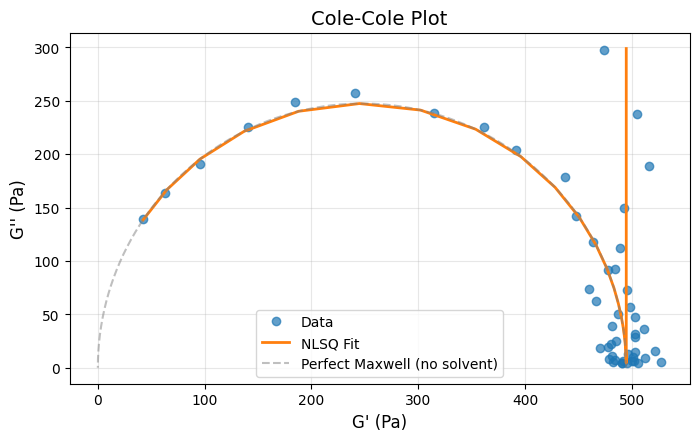


Cole-Cole Interpretation:
- Semicircle → Single relaxation time (Maxwell element)
- Deviation at high ω → Newtonian solvent contribution (η∞·ω)
- Multiple relaxation times would produce skewed/multiple arcs


In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data
ax.plot(G_prime_noisy, G_double_prime_noisy, 'o', 
        label='Data', markersize=6, alpha=0.7)

# Plot fitted curve
ax.plot(G_prime_fit, G_double_prime_fit, '-', 
        linewidth=2, label='NLSQ Fit', color='C1')

# Theoretical semicircle (no solvent contribution)
G_theory = fitted_params['G0']
theta = np.linspace(0, np.pi, 100)
G_prime_circle = G_theory / 2 * (1 + np.cos(theta))
G_double_prime_circle = G_theory / 2 * np.sin(theta)
ax.plot(G_prime_circle, G_double_prime_circle, '--', 
        linewidth=1.5, label='Perfect Maxwell (no solvent)', color='gray', alpha=0.5)

ax.set_xlabel("G' (Pa)", fontsize=12)
ax.set_ylabel("G'' (Pa)", fontsize=12)
ax.set_title('Cole-Cole Plot', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

display(fig)
plt.close(fig)

print("\nCole-Cole Interpretation:")
print("- Semicircle → Single relaxation time (Maxwell element)")
print("- Deviation at high ω → Newtonian solvent contribution (η∞·ω)")
print("- Multiple relaxation times would produce skewed/multiple arcs")

## 8. Save Results

In [13]:
# Create output directory
output_dir = Path("../outputs/dmt/saos")
output_dir.mkdir(parents=True, exist_ok=True)

# Save NLSQ results
nlsq_results = {
    'omega': omega,
    'G_prime_data': G_prime_noisy,
    'G_double_prime_data': G_double_prime_noisy,
    'G_prime_fit': G_prime_fit,
    'G_double_prime_fit': G_double_prime_fit,
    'fitted_params': fitted_params,
    'true_params': {k: calib_params[k] for k in ['G0', 'eta_0', 'eta_inf']}
}

np.savez(output_dir / 'nlsq_results.npz', **nlsq_results)

# Save Bayesian results
bayes_results = {
    'posterior_samples': bayes_result.posterior_samples,
    'G_prime_median': G_prime_median,
    'G_double_prime_median': G_double_prime_median,
    'G_prime_ci_lower': G_prime_lower,
    'G_prime_ci_upper': G_prime_upper,
    'G_double_prime_ci_lower': G_double_prime_lower,
    'G_double_prime_ci_upper': G_double_prime_upper
}

np.savez(output_dir / 'bayesian_results.npz', **bayes_results)

print(f"Results saved to {output_dir}/")
print("  - nlsq_results.npz")
print("  - bayesian_results.npz")

Results saved to ../outputs/dmt/saos/
  - nlsq_results.npz
  - bayesian_results.npz


## 9. Key Takeaways

### Theory
1. **Maxwell Equivalence**: At fixed structure (λ₀), DMT with elasticity is a single Maxwell element
2. **SAOS Limitations**: Linear oscillatory tests only probe G, η, η∞ - thixotropic parameters are invisible
3. **Crossover Frequency**: ω_c ≈ G/η provides the characteristic relaxation time

### Identifiability
4. **Only 3 Parameters**: G₀, η₀, η∞ can be determined from SAOS at fixed λ₀
5. **Thixotropic Degeneracy**: Different (a, c, t_eq, m_G) combinations give identical SAOS
6. **Transient Tests Required**: Need startup, creep, or step-strain to probe structure evolution

### Practical
7. **Preshear Matters**: SAOS depends on sample history (λ₀)
8. **Cole-Cole Diagnostic**: Semicircle confirms single relaxation mode
9. **Bayesian Uncertainty**: Credible intervals show parameter correlations (η₀ and G₀ trade off via θ₁)

### Next Steps
- **Notebook 06**: Combine SAOS + Startup → Fully constrain all 7 DMT parameters
- **Advanced**: LAOS (Large Amplitude) to probe nonlinear structure evolution during oscillation